In [24]:
# Importação do dataset armazenado no dw

from google.cloud import bigquery
import pandas as pd

client = bigquery.Client()

query = """
select 
    nome_produto
    , nome_cliente
    , regiao
    , ano
    , mes
    , data_base
    , quantidade
from `desafio-lh-445918`.public.agg_quantidade_loja

"""
df = client.query(query).to_dataframe()

df['data_base'] = pd.to_datetime(df['data_base'])

print(df.head())

df.to_csv('dataset_dw.csv')

/home/thiago/projects/desafio_lh/ds-venv/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


                   nome_produto nome_cliente      regiao   ano  mes  \
0            LL Road Handlebars    Good Toys  California  2013    7   
1  ML Road Frame-W - Yellow, 48    Good Toys  California  2014    5   
2  ML Road Frame-W - Yellow, 38    Good Toys  California  2014    5   
3  ML Road Frame-W - Yellow, 44    Good Toys  California  2013    1   
4     LL Road Frame - Black, 52    Good Toys  California  2013   10   

   data_base  quantidade  
0 2013-07-31           1  
1 2014-05-01           1  
2 2014-05-01           1  
3 2013-01-28           2  
4 2013-10-30           1  


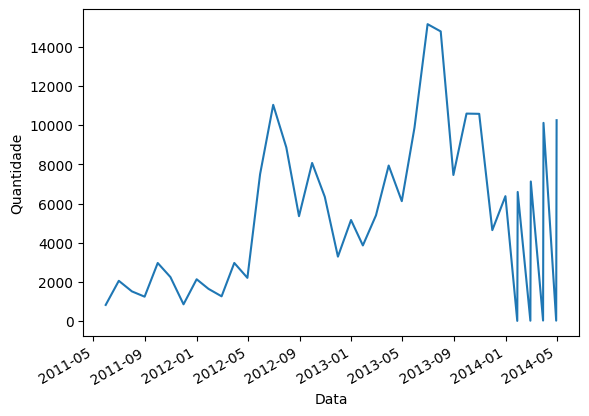

In [25]:
# Visualização das quantidades totais vendidas ao longo do tempo

import matplotlib.pyplot as plt

df.groupby('data_base')['quantidade'].sum().plot()
plt.xlabel('Data')
plt.ylabel('Quantidade')
plt.show()


In [26]:
# Preparação dos dados

import pandas as pd
from statsforecast.models import Naive
from statsforecast import StatsForecast

df_agrupada = df.groupby(['nome_produto', 'nome_cliente', 'regiao', 'data_base']).agg({'quantidade': 'sum'}).reset_index()

df_agrupada['data_base'] = pd.to_datetime(df_agrupada['data_base'])

dados_treino = df_agrupada[['data_base', 'quantidade', 'nome_produto', 'nome_cliente', 'regiao']].rename(columns={'data_base': 'ds', 'quantidade': 'y'})

dados_treino = dados_treino.sort_values(by='ds')

dados_treino['unique_id'] = dados_treino['nome_produto'] + "_" + dados_treino['nome_cliente'] + "_" + dados_treino['regiao']

dados_treino_grouped = dados_treino.groupby('unique_id')

print(dados_treino.head())


              ds  y             nome_produto               nome_cliente  \
41257 2011-05-31  1         Road-450 Red, 52           Pedals Warehouse   
37473 2011-05-31  2         Road-150 Red, 56              Weekend Tours   
47397 2011-05-31  3         Road-650 Red, 52        Health Spa, Limited   
29292 2011-05-31  3  Mountain-100 Silver, 38  Capable Sales and Service   
47857 2011-05-31  3         Road-650 Red, 60      Area Bike Accessories   

           regiao                                          unique_id  
41257     Georgia          Road-450 Red, 52_Pedals Warehouse_Georgia  
37473     Indiana             Road-150 Red, 56_Weekend Tours_Indiana  
47397      Canada        Road-650 Red, 52_Health Spa, Limited_Canada  
29292  Washington  Mountain-100 Silver, 38_Capable Sales and Serv...  
47857  California  Road-650 Red, 60_Area Bike Accessories_California  


In [27]:
# Para calcular a previsão da demanda, foi considerado somente os produtos que registraram venda em mais de 5 meses por cliente no período,
# pois a grande maioria dos produtos tiveram menos que 5 vendas por cliente (92,5%).

from statsforecast.models import Naive

dados_treino_filtrados = dados_treino.groupby('unique_id').filter(lambda x: len(x) > 5)

dados_treino_agrupados = dados_treino_filtrados.groupby('unique_id')

model = Naive()

forecast_resultados = {}
h = 3 

for unique_id, group in dados_treino_agrupados:
    y = group['y'].values
    forecast_resultado = model.forecast(y=y, h=h)
    forecast_resultados[unique_id] = forecast_resultado

for unique_id, resultado in forecast_resultados.items():
    print(f"Previsões para {unique_id}:")
    print(resultado)

Previsões para AWC Logo Cap_Advanced Bike Components_Texas:
{'mean': array([12., 12., 12.], dtype=float32)}
Previsões para AWC Logo Cap_Area Bike Accessories_California:
{'mean': array([5., 5., 5.], dtype=float32)}
Previsões para AWC Logo Cap_Better Bike Shop_Georgia:
{'mean': array([3., 3., 3.], dtype=float32)}
Previsões para AWC Logo Cap_Bike Dealers Association_New Mexico:
{'mean': array([12., 12., 12.], dtype=float32)}
Previsões para AWC Logo Cap_Bikes and Motorbikes_Canada:
{'mean': array([16., 16., 16.], dtype=float32)}
Previsões para AWC Logo Cap_Brightwork Company_Nevada:
{'mean': array([4., 4., 4.], dtype=float32)}
Previsões para AWC Logo Cap_Bulk Discount Store_United Kingdom:
{'mean': array([1., 1., 1.], dtype=float32)}
Previsões para AWC Logo Cap_Citywide Service and Repair_Canada:
{'mean': array([12., 12., 12.], dtype=float32)}
Previsões para AWC Logo Cap_Commerce Bicycle Specialists_United Kingdom:
{'mean': array([1., 1., 1.], dtype=float32)}
Previsões para AWC Logo Cap_C

In [28]:
# Resposta item 8
# Cálculo da previsão de demanda considerando os meses subsequentes à última venda de cada produto

ult_data = dados_treino['ds'].max()

forecast_lista = []

for unique_id, result in forecast_resultados.items():
    for i, forecast in enumerate(result['mean']):
        forecast_data = ult_data + pd.DateOffset(months=i+1)
        forecast_lista.append({
            'unique_id': unique_id,  
            'forecast_month': i + 1, 
            'forecast_data': forecast_data, 
            'forecast_quantity': forecast  
        })

forecast_df = pd.DataFrame(forecast_lista)

print(forecast_df)

forecast_df.to_csv("8_previsao_demanda.csv")

                                              unique_id  forecast_month  \
0           AWC Logo Cap_Advanced Bike Components_Texas               1   
1           AWC Logo Cap_Advanced Bike Components_Texas               2   
2           AWC Logo Cap_Advanced Bike Components_Texas               3   
3         AWC Logo Cap_Area Bike Accessories_California               1   
4         AWC Logo Cap_Area Bike Accessories_California               2   
...                                                 ...             ...   
5167      Sport-100 Helmet, Red_World of Bikes_Missouri               2   
5168      Sport-100 Helmet, Red_World of Bikes_Missouri               3   
5169  Sport-100 Helmet, Red_eCommerce Bikes_Mississippi               1   
5170  Sport-100 Helmet, Red_eCommerce Bikes_Mississippi               2   
5171  Sport-100 Helmet, Red_eCommerce Bikes_Mississippi               3   

     forecast_data  forecast_quantity  
0       2014-06-01               12.0  
1       2014-07-01 

In [29]:
# Divisão da coluna 'unique_id' em produto, cliente e região

forecast_df[['produto', 'cliente', 'regiao']] = forecast_df['unique_id'].str.split('_', expand=True)
print(forecast_df)

                                              unique_id  forecast_month  \
0           AWC Logo Cap_Advanced Bike Components_Texas               1   
1           AWC Logo Cap_Advanced Bike Components_Texas               2   
2           AWC Logo Cap_Advanced Bike Components_Texas               3   
3         AWC Logo Cap_Area Bike Accessories_California               1   
4         AWC Logo Cap_Area Bike Accessories_California               2   
...                                                 ...             ...   
5167      Sport-100 Helmet, Red_World of Bikes_Missouri               2   
5168      Sport-100 Helmet, Red_World of Bikes_Missouri               3   
5169  Sport-100 Helmet, Red_eCommerce Bikes_Mississippi               1   
5170  Sport-100 Helmet, Red_eCommerce Bikes_Mississippi               2   
5171  Sport-100 Helmet, Red_eCommerce Bikes_Mississippi               3   

     forecast_data  forecast_quantity                produto  \
0       2014-06-01               12

In [30]:
# Resposta do item 10

crescimento_regiao = forecast_df.groupby('regiao')['forecast_quantity'].sum().reset_index()

crescimento_regiao = crescimento_regiao.sort_values(by='forecast_quantity', ascending=False)

print("Crescimento por região nos três meses previstos:")
print(crescimento_regiao)

top_regiao = crescimento_regiao.iloc[0]
print(f"\nRegião com maior crescimento: {top_regiao['regiao']} (Demanda: {top_regiao['forecast_quantity']})")

crescimento_regiao.to_csv("10_regiao_maior_crescimento.csv")

Crescimento por região nos três meses previstos:
            regiao  forecast_quantity
2           Canada             4956.0
1       California             2190.0
25           Texas             2163.0
6           France             1206.0
29      Washington             1113.0
26  United Kingdom              978.0
3         Colorado              915.0
19        New York              585.0
17   New Hampshire              576.0
12        Michigan              471.0
15        Missouri              453.0
5          Florida              450.0
24       Tennessee              405.0
0          Arizona              399.0
18      New Mexico              396.0
4      Connecticut              291.0
28        Virginia              285.0
16          Nevada              276.0
7          Georgia              273.0
31         Wyoming              264.0
27            Utah              237.0
13       Minnesota              171.0
14     Mississippi              165.0
30       Wisconsin              165.0
1

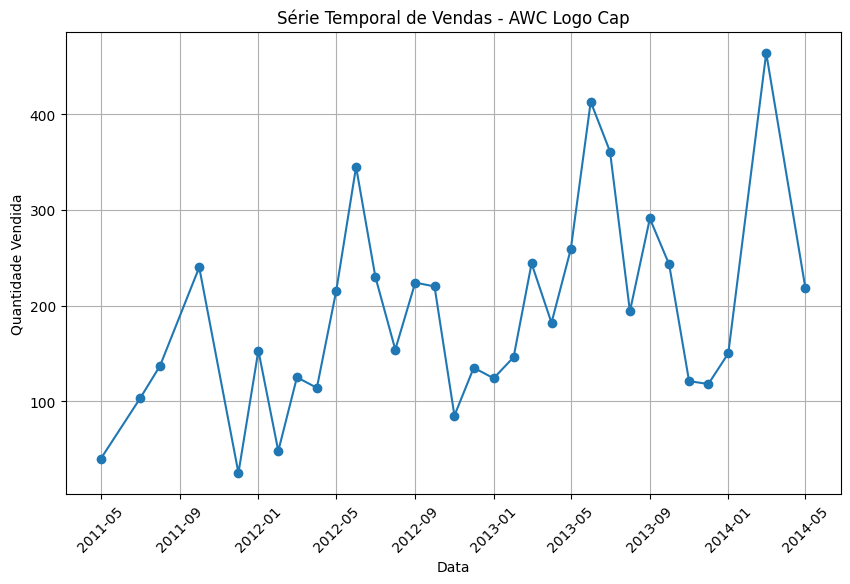

In [31]:
# Sazonalidade em um produto

produto = 'AWC Logo Cap'

df_produto = df[df['nome_produto'] == produto]

df_produto_mensal = df_produto.groupby(df_produto['data_base'].dt.to_period('M')).agg({'quantidade': 'sum'}).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df_produto_mensal['data_base'].dt.to_timestamp(), df_produto_mensal['quantidade'], marker='o')
plt.title(f'Série Temporal de Vendas - {produto}')
plt.xlabel('Data')
plt.ylabel('Quantidade Vendida')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [32]:
# Resposta do item 9

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

df['mes_num'] = df['data_base'].dt.month
df['ano_num'] = df['data_base'].dt.year

X = df[['ano_num', 'mes_num']] 
y = df['quantidade'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')


MAE: 2.0698577565739864
MSE: 8.879935718054025
RMSE: 2.9799220993264277
R²: 0.004667018097701869


In [33]:
# Resposta do item 11

produtos_alvo = [
    "Full-Finger Gloves, L",
    "Full-Finger Gloves, M",
    "Full-Finger Gloves, S",
    "Half-Finger Gloves, L",
    "Half-Finger Gloves, M",
    "Half-Finger Gloves, S"
]

forecast_filtro = forecast_df[forecast_df['produto'].isin(produtos_alvo)]

qtd_total = forecast_filtro['forecast_quantity'].sum()

resultado_final = qtd_total * 2

print(f"Estimativa da quantidade de zíperes para o novo fornecedor: {resultado_final}")


Estimativa da quantidade de zíperes para o novo fornecedor: 1668.0
